In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import multiprocessing as mp

# Isolation Tree 클래스 정의

class IsolationTreeEnsemble:
    def __init__(self, sample_size, n_trees=10):
        """
        IsolationTreeEnsemble 생성자.
        여러 개의 Isolation Tree를 만들기 위해 필요한 샘플 크기와 트리 수를 지정함.

        Parameters:
        sample_size (int): 각 트리에서 사용할 샘플 크기
        n_trees (int): 생성할 Isolation Tree의 개수
        """
        self.sample_size = sample_size
        self.n_trees = n_trees
        self.trees = []

        # 평균 경로 길이를 계산하기 위한 상수 c 계산
        self.c = self.tree_avg_length(self.sample_size)

    def fit(self, X:np.ndarray, improved=False):
        """
        IsolationTreeEnsemble에 포함될 트리들을 학습시키기.

        Parameters:
        X (np.ndarray): 학습 데이터 (2차원 배열)
        improved (bool): 개선된 알고리즘을 사용할지 여부

        Returns:
        self: 학습이 완료된 IsolationTreeEnsemble 객체
        """
        if isinstance(X, pd.DataFrame):
            X = X.values

        # 트리의 최대 높이를 log2(샘플 크기)로 설정하기
        height_limit = int(np.ceil(np.log2(self.sample_size)))

        # 지정된 개수만큼 트리를 생성하기
        for n in range(self.n_trees):
            # 데이터에서 무작위로 샘플링하기
            sample_rows = np.random.choice(X.shape[0], size=self.sample_size, replace=False)
            tree = IsolationTree(height_limit)
            tree.fit(X[sample_rows], improved)
            self.trees.append(tree)

        return self

    def path_length(self, X:np.ndarray) -> np.ndarray:
        """
        주어진 데이터 포인트에 대해 각 트리에서 경로 길이를 계산하여 평균 경로 길이를 반환하기.

        Parameters:
        X (np.ndarray): 테스트 데이터 (2차원 배열)

        Returns:
        np.ndarray: 각 데이터 포인트의 평균 경로 길이
        """
        if isinstance(X, pd.DataFrame):
            X = X.values

        # 각 데이터 포인트에 대해 경로 길이를 계산하기
        paths = np.zeros(X.shape[0], dtype=float)
        with mp.Pool(8) as p:
            paths = p.map(self._path_len, X)

        return np.array(paths)

    def _path_len(self, x):
        """
        단일 데이터 포인트에 대해 모든 트리에서 경로 길이를 계산하여 평균 경로 길이를 반환하기.

        Parameters:
        x (np.ndarray): 단일 데이터 포인트 (1차원 배열)

        Returns:
        float: 데이터 포인트의 평균 경로 길이
        """
        length = 0.0
        for tree in self.trees:
            length += self.tree_path_length(x, tree.root, 0)
        mean = length / self.n_trees
        return mean

    def tree_avg_length(self, size):
        """
        주어진 샘플 크기에 대한 평균 경로 길이를 계산하기.

        Parameters:
        size (int): 샘플 크기

        Returns:
        float: 평균 경로 길이
        """
        if size > 2:
            harmonic_number = np.log(size - 1.) + 0.5772156649
            return (2. * harmonic_number) - (2. * (size - 1.) / size)
        elif size == 2:
            return 1.
        else:
            return 0.

    def tree_path_length(self, X, root, current_path_length):
        """
        단일 트리에서 주어진 데이터 포인트의 경로 길이를 재귀적으로 계산하기.

        Parameters:
        X (np.ndarray): 단일 데이터 포인트 (1차원 배열)
        root (inNode/exNode): 트리의 루트 노드
        current_path_length (int): 현재까지의 경로 길이

        Returns:
        float: 최종 경로 길이
        """
        if isinstance(root, exNode):
            return current_path_length + self.tree_avg_length(root.size)

        split_at = root.q

        if X[split_at] < root.p:
            return self.tree_path_length(X, root.left, current_path_length + 1)
        else:
            return self.tree_path_length(X, root.right, current_path_length + 1)

    def anomaly_score(self, X:np.ndarray) -> np.ndarray:
        """
        주어진 데이터 포인트의 이상 점수를 계산하기.

        Parameters:
        X (np.ndarray): 테스트 데이터 (2차원 배열)

        Returns:
        np.ndarray: 각 데이터 포인트의 이상 점수
        """
        path_lengths = self.path_length(X)
        return 2.0 ** (-path_lengths / self.c)

    def predict_from_anomaly_scores(self, scores:np.ndarray, threshold:float) -> np.ndarray:
        """
        이상 점수에 따라 주어진 임계값을 사용해 이상 여부를 예측하기.

        Parameters:
        scores (np.ndarray): 이상 점수 (1차원 배열)
        threshold (float): 이상으로 간주할 임계값

        Returns:
        np.ndarray: 예측 결과 (0: 정상, 1: 이상)
        """
        s = scores.copy()
        s[s < threshold] = 0
        s[s >= threshold] = 1
        return s

    def predict(self, X:np.ndarray, threshold:float) -> np.ndarray:
        """
        주어진 데이터에 대해 이상 점수를 계산하고 임계값을 사용해 이상 여부를 예측하기.

        Parameters:
        X (np.ndarray): 테스트 데이터 (2차원 배열)
        threshold (float): 이상으로 간주할 임계값

        Returns:
        np.ndarray: 예측 결과 (0: 정상, 1: 이상)
        """
        return self.predict_from_anomaly_scores(self.anomaly_score(X), threshold)





In [4]:
# Isolation Tree Ensemble 클래스 정의
class IsolationTree:
    def __init__(self, height_limit):
        """
        IsolationTree 생성자.
        트리의 최대 높이를 지정하고, 노드 개수를 초기화함.

        Parameters:
        height_limit (int): 트리의 최대 높이
        """
        self.height_limit = height_limit
        self.n_nodes = 0

    def fit(self, X:np.ndarray, improved=False):
        """
        주어진 데이터로 Isolation Tree를 학습하기.

        Parameters:
        X (np.ndarray): 학습 데이터 (2차원 배열)
        improved (bool): 개선된 알고리즘을 사용할지 여부

        Returns:
        inNode/exNode: 트리의 루트 노드
        """
        self.root = self.make_node(X, 0, improved)
        return self.root

    def make_node(self, X, current_height, improved):
        """
        주어진 데이터를 사용해 트리의 노드를 재귀적으로 생성하기.

        Parameters:
        X (np.ndarray): 학습 데이터 (2차원 배열)
        current_height (int): 현재 노드의 높이
        improved (bool): 개선된 알고리즘을 사용할지 여부

        Returns:
        inNode/exNode: 생성된 노드 (내부 노드 또는 외부 노드)
        """
        self.n_nodes += 1
        if current_height >= self.height_limit or X.shape[0] <= 1:
            return exNode(X.shape[0])

        if improved:
            qs = np.random.randint(0, X.shape[1], 2)

            best_q = qs[0]
            best_p = 0
            best__ = 0

            leftX = None
            rightX = None
            for q in qs:
                minimum = X[:,q].min()
                maximum = X[:,q].max()
                p = np.random.uniform(minimum, maximum)

                tmp_leftX = X[X[:,q]<p]
                tmp_rightX = X[X[:,q]>=p]

                left_len = len(tmp_leftX)
                right_len = len(tmp_rightX)

                var = abs(left_len - right_len)

                if var >= best__:
                    best__ = var
                    best_q = q
                    best_p = p

                    leftX = tmp_leftX
                    rightX = tmp_rightX

            q = best_q
            p = best_p

        else:
            q = np.random.randint(0, X.shape[1])
            minimum = X[:,q].min()
            maximum = X[:,q].max()
            p = np.random.uniform(minimum, maximum)

            leftX = X[X[:,q]<p]
            rightX = X[X[:,q]>=p]

        left = self.make_node(leftX, current_height+1, improved)
        right = self.make_node(rightX, current_height+1, improved)

        return inNode(left, right, q, p)

In [5]:
class inNode:
    def __init__(self, left, right, q, p):
        """
        내부 노드(inNode) 클래스 생성자.

        Parameters:
        left (inNode/exNode): 좌측 자식 노드
        right (inNode/exNode): 우측 자식 노드
        q (int): 분할 기준이 되는 feature index
        p (float): 분할 기준이 되는 값
        """
        self.left = left
        self.right = right
        self.q = q
        self.p = p


In [6]:
class exNode:
    def __init__(self, size):
        """
        외부 노드(exNode) 클래스 생성자.
        트리의 리프 노드를 나타내며, 노드에 포함된 데이터의 크기를 저장함.

        Parameters:
        size (int): 노드에 포함된 데이터의 크기
        """
        self.size = size


In [7]:
def find_TPR_threshold(y, scores, desired_TPR):
    """
    주어진 TPR(참 양성 비율)을 달성하기 위한 임계값을 찾는 함수.

    Parameters:
    y (np.ndarray): 실제 라벨 값 (0: 정상, 1: 이상)
    scores (np.ndarray): 이상 점수 (1차원 배열)
    desired_TPR (float): 원하는 TPR 값 (예: 0.95)

    Returns:
    threshold (float): 원하는 TPR을 달성하는 이상 점수의 임계값
    FPR (float): 이 임계값에서의 FPR (거짓 양성 비율)
    """
    threshold = 1.0
    TPR = 0.0
    FPR = 0.0

    # TPR이 desired_TPR에 도달할 때까지 임계값을 감소시키면서 계산하기
    while TPR < desired_TPR:
        temp = scores.copy()
        temp[temp < threshold] = 0
        temp[temp >= threshold] = 1

        # 혼동 행렬(confusion matrix)을 계산하여 TPR과 FPR을 계산하기
        confusion = confusion_matrix(y, temp)
        if confusion.size != 4:  # TN, FP, FN, TP = confusion.flat
            break
        TN, FP, FN, TP = confusion.flat
        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)

        threshold -= 0.01

    return threshold + 0.01, FPR

[[560   0]
 [  7  33]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       560
           1       1.00      0.82      0.90        40

    accuracy                           0.99       600
   macro avg       0.99      0.91      0.95       600
weighted avg       0.99      0.99      0.99       600



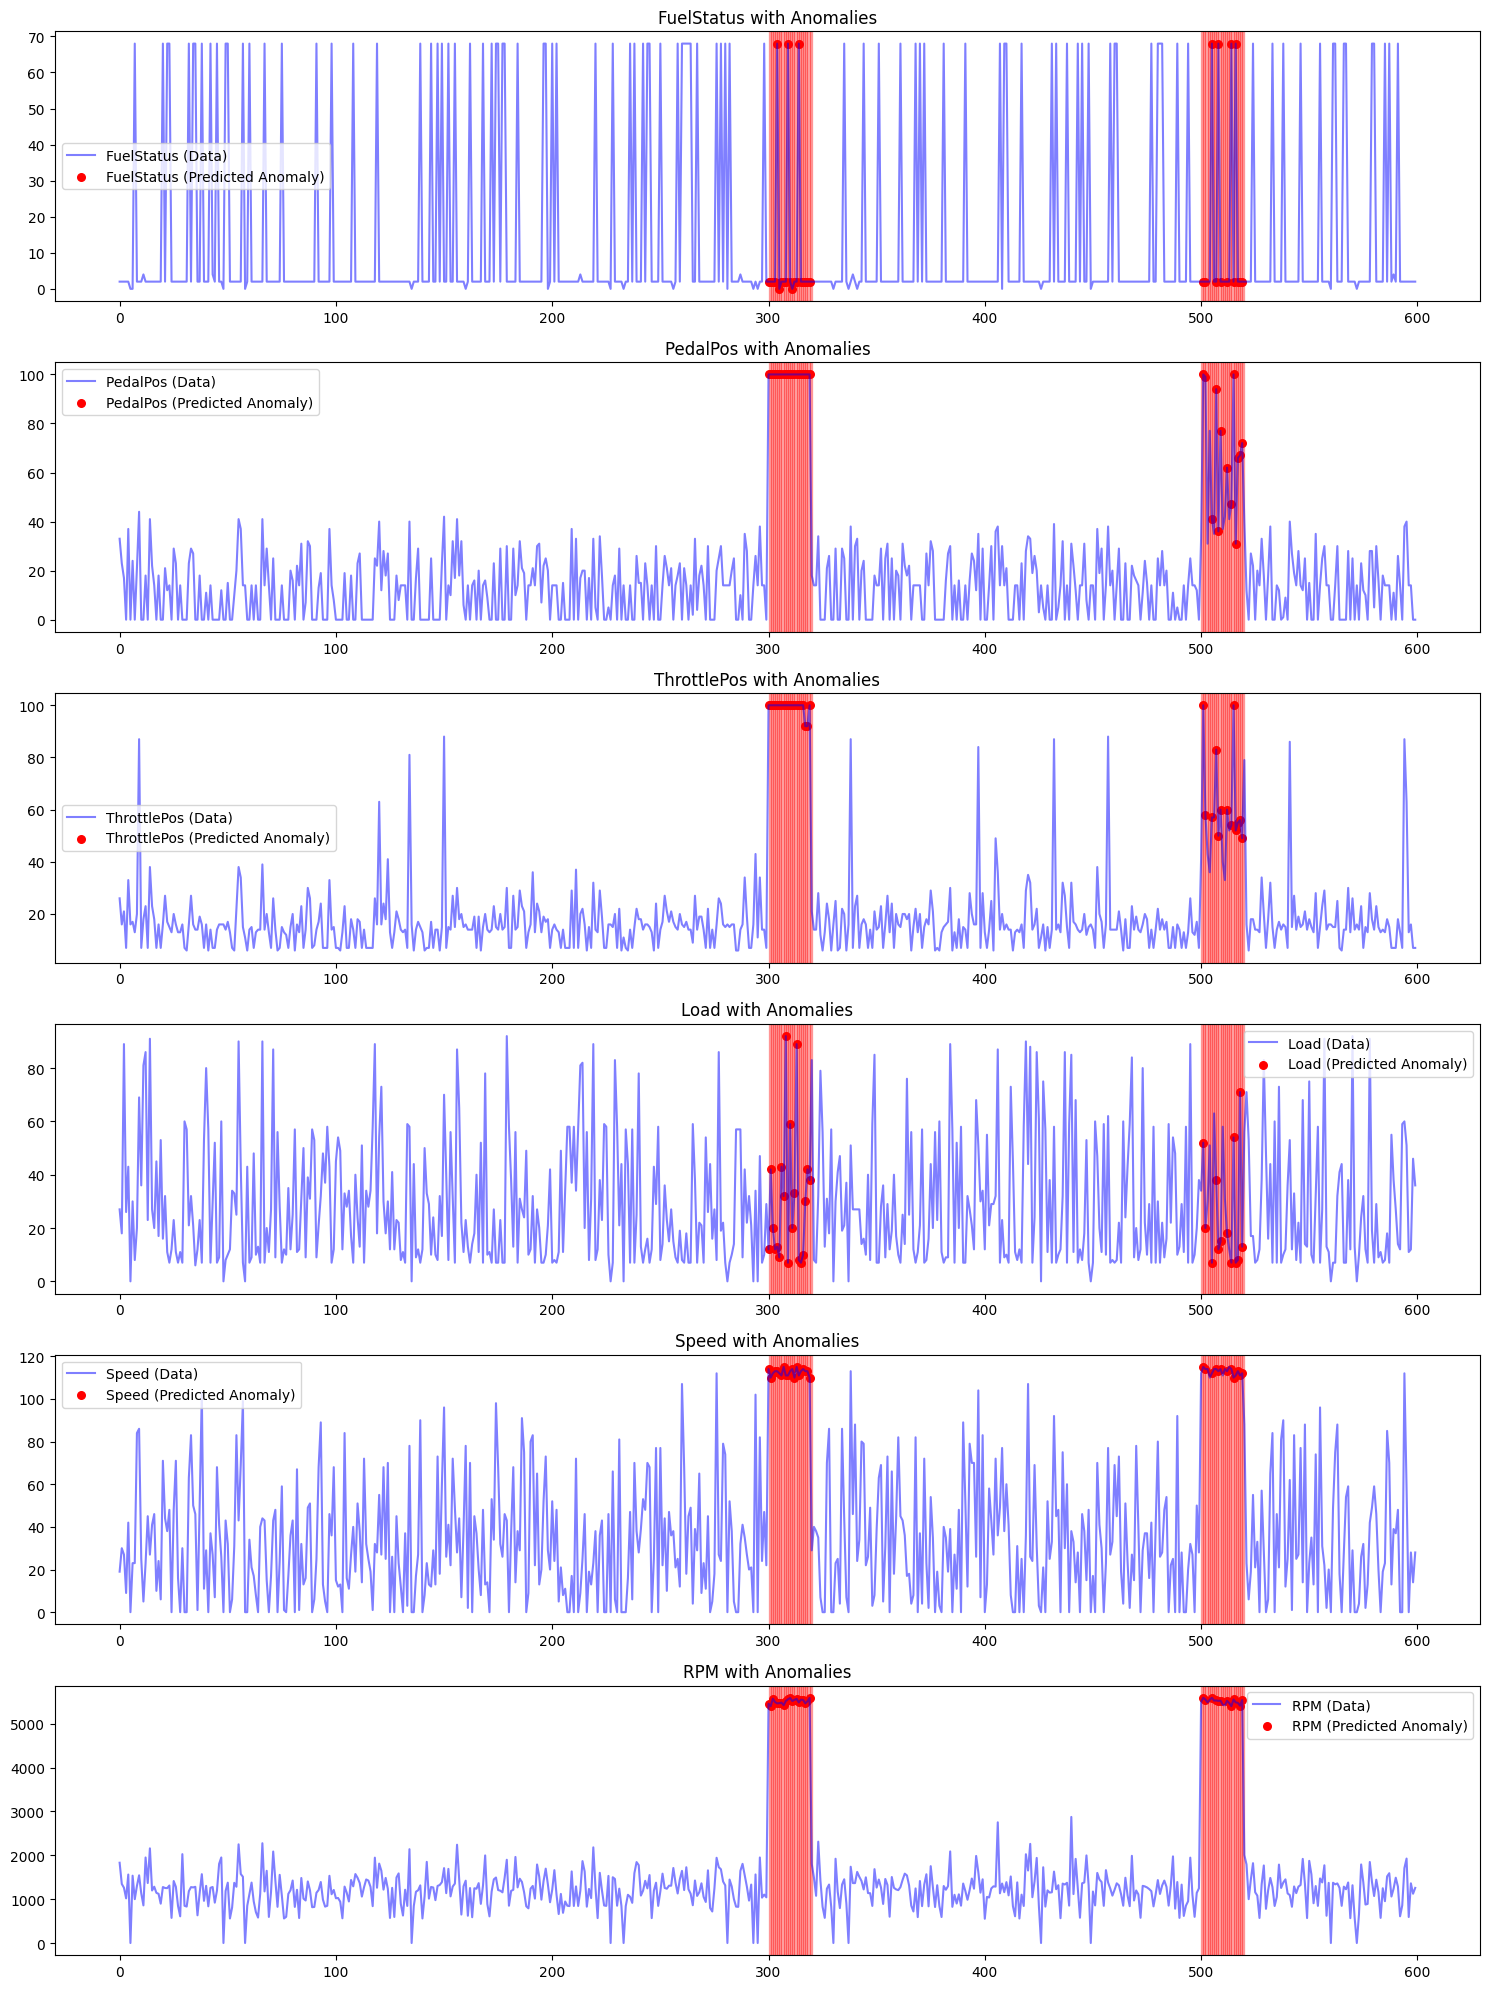

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# IsolationTreeEnsemble 클래스를 사용하여 학습하고 이상치 탐지하는 코드 (이전 설명 코드 사용)

# 데이터 로드 및 전처리
train_data_path = '/content/drive/MyDrive/라온 팀폴더/데이터셋/OBDdata/sorted_combined_file_no_duplicates.csv'  # 학습용 정상 데이터
df_train = pd.read_csv(train_data_path)
target_columns = ['FuelStatus', 'PedalPos', 'ThrottlePos', 'Load', 'Speed', 'RPM']
X_train = df_train[target_columns].values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# IsolationTreeEnsemble 모델 학습
sample_size = 256
ensemble = IsolationTreeEnsemble(sample_size=sample_size, n_trees=100)
ensemble.fit(X_train_scaled)

# 테스트 데이터 로드
test_data_path = '/content/simulated_double_sudden_acceleration_with_label.csv'  # 테스트 데이터
df_test = pd.read_csv(test_data_path)
X_test = df_test[target_columns].values
y_test = df_test['label'].values
X_test_scaled = scaler.transform(X_test)

# 이상 점수 계산 및 임계값 설정
anomaly_scores = ensemble.anomaly_score(X_test_scaled)
desired_TPR = 0.80
threshold, FPR = find_TPR_threshold(y_test, anomaly_scores, desired_TPR)

# 새로운 임계값으로 예측
y_pred = ensemble.predict_from_anomaly_scores(anomaly_scores, threshold)

# 성능 평가
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 이상 탐지된 위치 시각화
anomalies = np.where(y_pred == 1)[0]

# Plotting results with shaded areas for actual anomalies and red dots for detected anomalies
fig, axs = plt.subplots(len(target_columns), 1, figsize=(15, 20))

for i, feature in enumerate(target_columns):
    # 실제 이상 라벨 구간을 색칠된 영역으로 표시
    axs[i].plot(df_test.index, df_test[feature], label=f'{feature} (Data)', color='b', alpha=0.5)

    for j in range(len(y_test)):
        if y_test[j] == 1:
            axs[i].axvspan(j, j+1, color='red', alpha=0.3)  # 이상 구간을 색칠된 영역으로 표시

    # 예측된 이상점은 붉은 점으로 표시
    axs[i].scatter(anomalies, df_test[feature].iloc[anomalies], color='r', label=f'{feature} (Predicted Anomaly)', marker='o', s=30)

    axs[i].set_title(f'{feature} with Anomalies')
    axs[i].legend()

plt.tight_layout()
plt.show()
